<a href="https://colab.research.google.com/github/tchintchie/Data-Scientist-In-Python/blob/master/cnn_antholzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import urllib.request
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data=urllib.request.urlretrieve("https://homepages.cae.wisc.edu/~ece533/images/peppers.png")

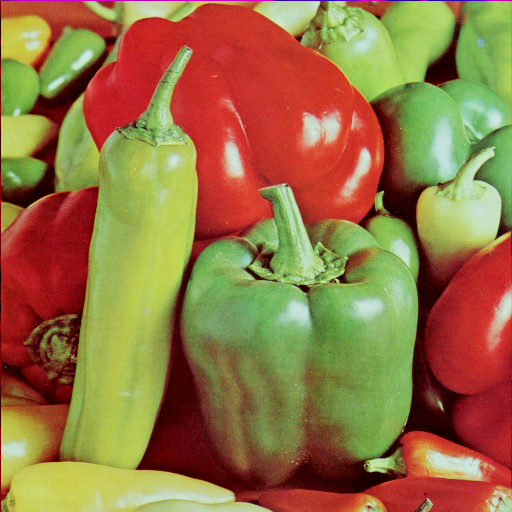

In [4]:
img = PIL.Image.open(data[0])
img

In [5]:
def plot(xs):
    fig, ax = plt.subplots(1,len(xs), figsize=(12,6))
    for k in range(len(xs)):
        x = xs[k]
        if torch.is_tensor(x):
            y = x.detach().cpu().numpy().squeeze(0).transpose([1,2,0])
        elif PIL.Image.isImageType(x):
            y = np.array(x)
        else:
            y = x
        if len(y.shape) == 2:
            ax[k].imshow(y, cmap="gray")
        else:
            ax[k].imshow(y)
    fig.tight_layout()
    
x = torch.from_numpy(np.expand_dims(np.array(img).astype("float32").transpose([-1,0,1]), 0)/255)

In [6]:
#first we create an object that stores the weights/parameters of the convolution operator
# we have 3 input channels, 1 output channels, a kernel size of 1 (the first three parameters of this function)
conv1 = nn.Conv2d(3, 1, 1, bias=False)
fil = torch.tensor([1/3, 1/3, 1/3]).reshape(1,3,1,1)
conv1.weight = nn.Parameter(fil) # pytorch expects the convolution weights to be parameters, since it is usually used inside a CNN

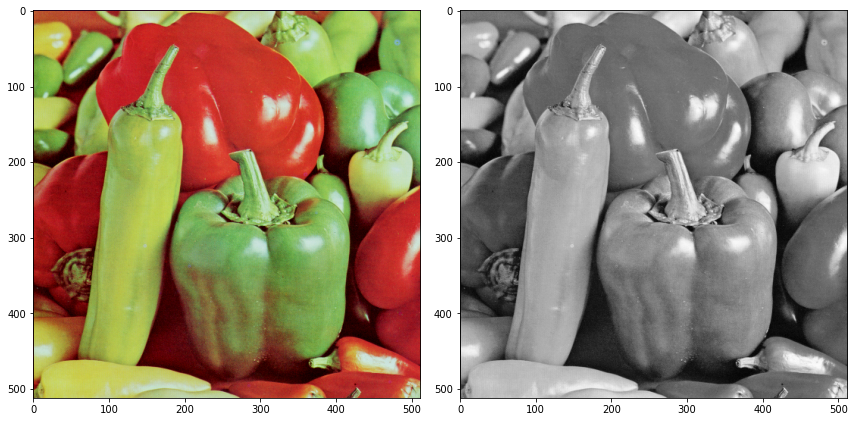

In [7]:
plot([x, conv1(x).squeeze().detach().numpy()])

In [8]:
conv2 = nn.Conv2d(1, 1, 3, padding=1, bias=False)
fil = torch.tensor([[0,-1,0], [-1,4,-1],[0,-1,0]], dtype=torch.float32)
print(fil)
fil = fil.reshape(1,1,3,3)
conv2.weight = nn.Parameter(fil) 

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])


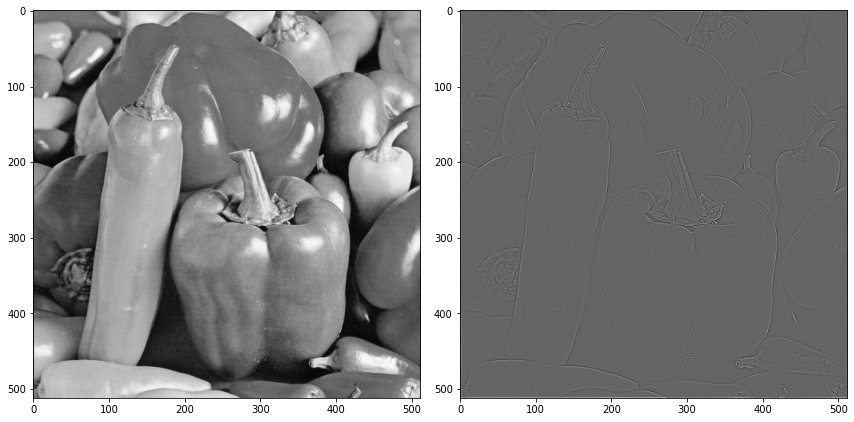

In [9]:
plot([conv1(x).squeeze().detach().numpy(), conv2(conv1(x)).squeeze().detach().numpy()])

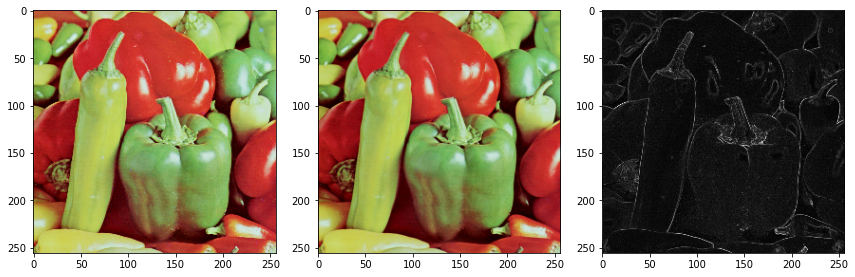

In [10]:
# max and average pooling only differ on edges, since we only used a 2x2 kernel
# also note the number of pixels in the images
plot([nn.MaxPool2d(2,2)(x), nn.AvgPool2d(2,2)(x),
      torch.mean(nn.MaxPool2d(2,2)(x)-nn.AvgPool2d(2,2)(x), dim=1).cpu().numpy().squeeze()])

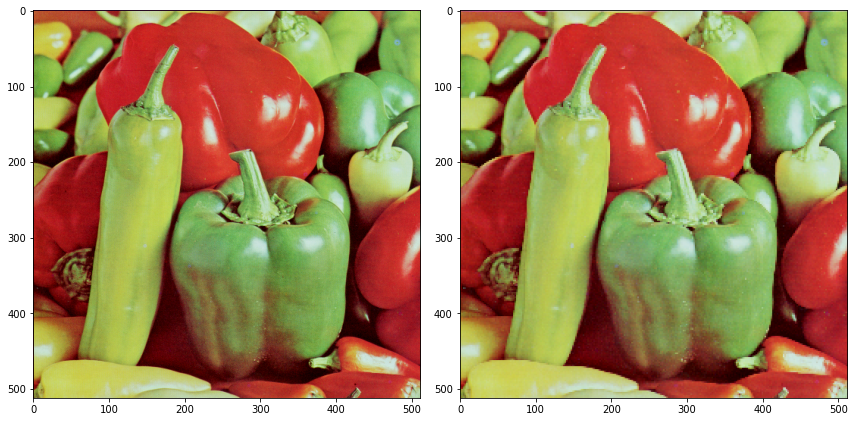

In [11]:
down = nn.MaxPool2d(2,2)(x)
plot([x, nn.functional.interpolate(down, scale_factor=2)])

In [12]:
# transposed convolution
conv = nn.Conv2d(3, 1, 3, padding=1)
convt = nn.ConvTranspose2d(1, 3, 3, padding=1)
xc = conv(x)
print("input shape ", x.shape)
print("conv shape ", xc.shape)
print("conv transposed after conv shape ", convt(xc).shape)
# in order to reverse the down sampling of maxpool we need to define a transposed convolution like this
# note that this are the same parameters as used in the pooling layer
convt = nn.ConvTranspose2d(3, 3, 2, stride=2, padding=0)
print("max pool shape ", down.shape)
print("conv transposed after maxpool shape ", convt(down).shape)

input shape  torch.Size([1, 3, 512, 512])
conv shape  torch.Size([1, 1, 512, 512])
conv transposed after conv shape  torch.Size([1, 3, 512, 512])
max pool shape  torch.Size([1, 3, 256, 256])
conv transposed after maxpool shape  torch.Size([1, 3, 512, 512])


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, residual=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 4, padding=1, stride=2)
        self.conv2 = nn.Conv2d(8, 16, 4, padding=1, stride=2)
        self.conv2t = nn.ConvTranspose2d(16, 8, 4, padding=1, stride=2)
        self.conv1t = nn.ConvTranspose2d(8, 1, 4, padding=1, stride=2)
        self.act = nn.ReLU()
        self.residual = residual
        
    def forward(self, inputs):
        x = self.act(self.conv2(self.act(self.conv1(inputs))))
        x = self.conv1t(self.act(self.conv2t(x)))
        if self.residual:
            x = inputs + x
        return x

In [14]:
from torch.utils.data import TensorDataset, DataLoader
b = torch.cat([x[0,0,k:k+64,j:j+64].reshape(1,1,64,64) for k in range(0,256,4) for j in range(0,256,4)])
train_loader = DataLoader(TensorDataset(b+0.005*torch.randn(*b.shape), b), batch_size=8)

In [15]:
net = SimpleCNN()
res_net = SimpleCNN(True)
opt1 = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.7)
opt2 = torch.optim.SGD(res_net.parameters(), lr=0.01, momentum=0.7)

In [16]:
# if a GPU can be used it will significantly speed up the training process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
res_net.to(device)
device

device(type='cpu')

In [17]:
# one loop over the whole dataset
def train(model, opt):
    avg_loss = 0
    for x, y in train_loader:
        # move x, y to the same device as the CNN (does nothing if it's already on the same)
        x, y = x.to(device), y.to(device)
        # apply the CNN
        out = model(x)
        # calculate the mean absolute distance
        loss = torch.mean(torch.abs(out - y))
        # before we calculate the gradients we need to set the gradients of the last minibatch to zero
        opt.zero_grad()
        # calculate gradients via backpropagation
        loss.backward()
        # update parameters via SGD
        opt.step()
        # the loss is a tensor with 1 element, with item we extract that into a python float
        avg_loss += loss.item()
    return avg_loss/len(train_loader)

In [18]:
for e in range(5):
    loss = train(net, opt1)
    print("{:.03e}  ".format(loss), end="")

1.363e-01  9.673e-02  4.585e-02  3.412e-02  3.083e-02  

In [19]:
for e in range(5):
    loss = train(res_net, opt2)
    print("{:.03e}  ".format(loss), end="")

4.950e-03  3.989e-03  3.989e-03  3.989e-03  3.989e-03  

MAE error  0.032973662
res_net MAE error  0.0040737167


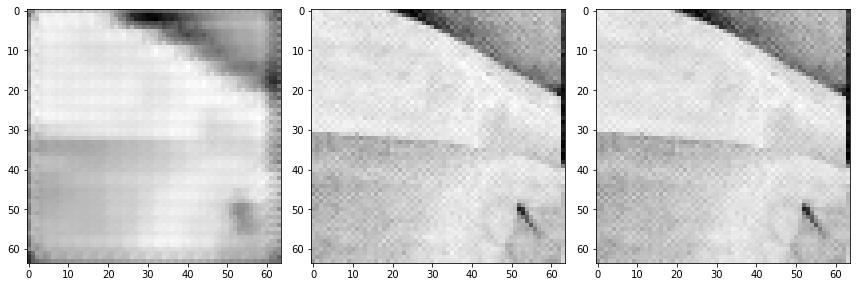

In [20]:
test = x[0,0,-64:,-64:].reshape(1,1,64,64)
test = (test + torch.randn(1,1,64,64)*0.005).to(device)
true = x[0,0,-64:,-64:].numpy().squeeze()
o = list(map(lambda x: x.detach().cpu().numpy().squeeze(), [net(test), res_net(test)]))
print("MAE error ", np.mean(np.abs(true-o[0])))
print("res_net MAE error ", np.mean(np.abs(true-o[1])))
plot([*o, true])

In [21]:
# save weights to file
torch.save(res_net.state_dict(), "weights.pth")